# Manuscript Content

This notebook generates all of the figures and tables for the manuscript exploring the indicators derived from the algorithm developed in this repository and their relationship with the indicators in the NSIDC-0747 dataset, currently referred to as the "Steele" indicators throughout. And appendix is provided at the end of this document. 

In [1]:
import copy
import os
import warnings
import numpy as np
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as rio
import rioxarray
import seaborn as sns
import xarray as xr
from pyproj import Transformer
from rasterio.crs import CRS
from rasterio.plot import show
from rasterstats import zonal_stats
from shapely.geometry import Polygon

In [2]:
os.environ["BASE_DIR"] = "/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data"
os.environ["OUTPUT_DIR"] = "/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products"
os.environ["SCRATCH_DIR"] = "/atlas_scratch/kmredilla/seaice_noaa_indicators"

In [3]:
def assimilate_orac(orac):
    """Replicate the data strcutre of FUBU dataset 
    in the ORAC dataset so they can be used with same functions

    Args:
        orac: Steele (NSIDC-0747) indicators xarray.dataset
        fubu: J&H indicators xarray.dataset
        
    Returns:
        ORAC dataset matching the structure of the FUBU indicators
            dataset
    """
    # retain only variables that correspond to FUBU indicators
    # rename coord vars to match
    varnames = ["DOO", "DOR", "DOA", "DOC"]
    orac = orac[varnames].rename({"x": "xc", "y": "yc", "time": "year"})
    # make time variable an integer with year
    orac = orac.assign_coords(year=[dt.year for dt in orac["year"].values])
    # set non-indicator date values to np.nan
    for var in varnames:
        orac[var].values[orac[var].values < 1] = np.nan

    return orac

In [4]:
out_dir = Path(os.getenv("OUTPUT_DIR")).joinpath("manuscript_content")
out_dir.mkdir(exist_ok=True)
base_dir = Path(os.getenv("BASE_DIR"))
scratch_dir = Path(os.getenv("SCRATCH_DIR"))

# load data
fubu_fp = base_dir.joinpath("nsidc_0051/outputs/nsidc_0051_1979-2019_fubu.nc")
orac_fp = base_dir.joinpath(
    "nsidc_0747/arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc"
)

fubu = xr.load_dataset(fubu_fp)
# Data for Steele only available through 2017. Reduce J&E timespan to match
fubu = fubu.sel(year=slice(1979, 2017))
# set data to floats and np.nan for more straightforward processing
for indicator in list(fubu.variables())[:4]:
    fubu[indicator] = fubu[indicator].astype(float)
    fubu[indicator].values[fubu[indicator].values == -9999.] = np.nan

orac = xr.load_dataset(orac_fp)
# Since a number of plots involve both Steele and J&H,
# give them a similar data structure for consistent use
# plotting functions
orac = assimilate_orac(orac)

In [5]:
orac_fp = base_dir.joinpath(
    "nsidc_0747/arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc"
)

with xr.open_rasterio(f"netcdf:{orac_fp}:DOA") as da:
    landmask = da.sel(band=1).values == -4

In [22]:
def save_fig(fp):
    plt.savefig(fp, dpi=300, bbox_inches="tight", facecolor="white")
    print(f"Plot written to {fp}")
    
    return


def make_totals_maps(ds, varnames, landmask, titles, out_fp):
    """Make the totals maps - heatmaps of
    pixel-wise counts of years where indicator was defined -
    for a supplied indicators dataset and variable names

    Args:
        ds (xarray.Dataset): indicator Dataset
        varnames (list): names of variables in ds to count and plot totals for
        landmask (np.ndarray): array where values of true correspond to pixels
            that overlap land
        landmask_poly (geopandas.GeoDataFrame): polgyon of the
            landmask
        out_fp (path-like): absolute path to image write location

    Returns:
        None, writes image to out_fp
    """

    def prep_totals(var):
        """Count totals and add landmask"""
        arr = ds[var].values.copy()
        valid = np.isnan(arr) == False
        counts = np.sum(valid, axis=0)
        plot_arr = np.ma.masked_where(landmask, counts)

        return plot_arr.astype("int32")

    plot_arrs = [prep_totals(var) for var in varnames]

    # plot data
    cmap = copy.copy(plt.cm.get_cmap("viridis"))
    cmap.set_bad(color="gray")
    cmap.set_under(color="white")
    fig, axs = plt.subplots(1, 2, figsize=(10, 7.5))

    # need to write temporary raster for plotting

    for arr, ax, title in zip(plot_arrs, axs, titles):
        # with rio.open("temp.tif", "w+", **meta) as src:
        # src.write(arr, 1)
        im = ax.imshow(arr, interpolation="none", cmap=cmap, vmin=1, vmax=39)
        # im = show((src, 1), ax=ax)
        # landmask_poly.plot(ax=ax, facecolor='none', edgecolor="gray")
        ax.set_title(title, fontdict={"fontsize": 12})
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(wspace=-0.25, right=0.95, left=0.01)
    # cbar_ax = fig.add_axes([0.85, 0.18, 0.1, 0.8])
    # cbar = fig.colorbar(im, cax=cbar_ax)
    cax = ax.inset_axes([1.04, 0.2, 0.05, 0.6], transform=ax.transAxes)
    cbar = fig.colorbar(im, ax=axs, cax=cax, shrink=1.2)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label("Years where indicator defined", rotation=270, labelpad=14)
    # fig.tight_layout()
    # initial journal consideration: The Cryosphere, min width 8cm (3.15in)
    fig.set_size_inches(10, 7.5)
    save_fig(out_fp)
    plt.show()

    return

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/Johnson_Eicken_totals_maps.png


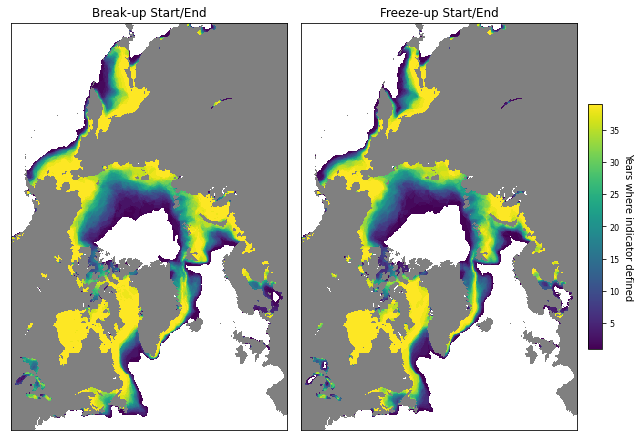

In [23]:
output_format = "png"
#output_format = "eps"

make_totals_maps(
    fubu,
    ["breakup_start", "freezeup_start"],
    landmask,
    # landmask_poly,
    # meta,
    ["Break-up Start/End", "Freeze-up Start/End"],
    out_dir.joinpath(f"Johnson_Eicken_totals_maps.{output_format}"),
)

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/Steele_totals_maps.png


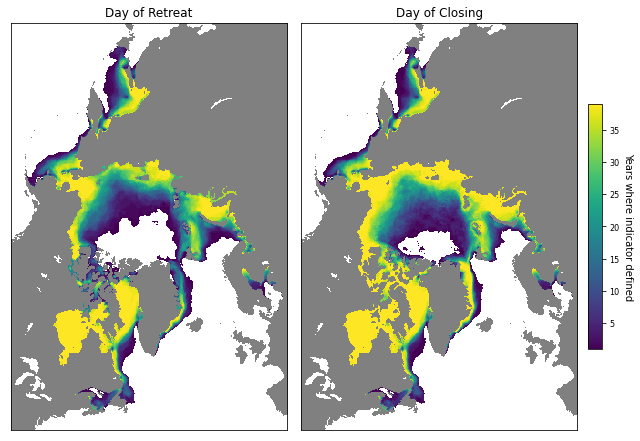

In [24]:
output_format = "png"
#output_format = "eps"

make_totals_maps(
    orac,
    ["DOR", "DOC"],
    landmask,
    # landmask_poly,
    # meta,
    ["Day of Retreat", "Day of Closing"],
    out_dir.joinpath(f"Steele_totals_maps.{output_format}"),
)


In [25]:
def prep_isl_arr(arr, landmask):
    mean_arr = np.nanmean(arr, 0)
    mean_arr[np.isnan(mean_arr)] = 0
    
    return np.ma.masked_where(landmask, mean_arr)

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/ice_season_length_maps.png


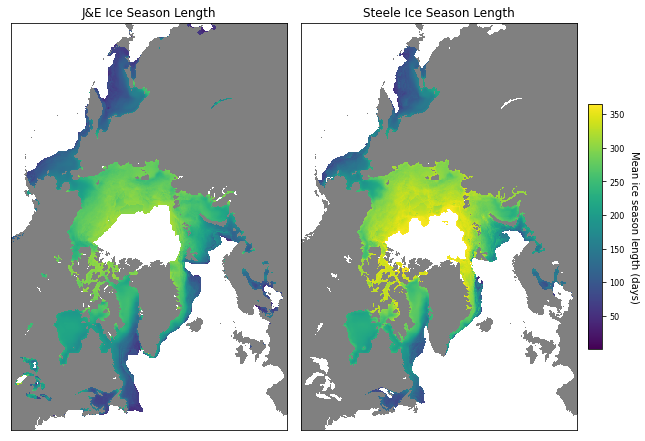

In [26]:
output_format = "png"
#output_format = "eps"

fubu_isl = (fubu["breakup_end"].values + 365) - fubu["freezeup_start"].values
orac_isl = (orac["DOR"].values + 365) - orac["DOA"].values

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    isl_arrs = [prep_isl_arr(arr, landmask) for arr in [fubu_isl, orac_isl]]

# plot data
cmap = copy.copy(plt.cm.get_cmap("viridis"))
cmap.set_bad(color="gray")
cmap.set_under(color="white")
fig, axs = plt.subplots(1, 2, figsize=(10, 7.5))

for arr, ax in zip(isl_arrs, axs):
    im = ax.imshow(arr, interpolation="none", cmap=cmap, vmin=1, vmax=365)
    ax.set_xticks([])
    ax.set_yticks([])

axs[0].set_title("J&E Ice Season Length", fontdict={"fontsize": 12})
axs[1].set_title("Steele Ice Season Length", fontdict={"fontsize": 12})

fig.subplots_adjust(wspace=-0.25, right=0.95, left=0.01)
# cbar_ax = fig.add_axes([0.85, 0.18, 0.1, 0.8])
# cbar = fig.colorbar(im, cax=cbar_ax)
cax = ax.inset_axes([1.04, 0.2, 0.05, 0.6], transform=ax.transAxes)
cbar = fig.colorbar(im, ax=axs, cax=cax, shrink=1.2)
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Mean ice season length (days)", rotation=270, labelpad=14)
# fig.tight_layout()
# initial journal consideration: The Cryosphere, min width 8cm (3.15in)
fig.set_size_inches(10, 7.5)

save_fig(out_dir.joinpath(f"ice_season_length_maps.{output_format}"))

plt.show()

In [27]:
def get_polygon(row):
    """Create shapely polygon object from row of alternating
    lat/lon coords

    Args:
        pandas series object from df.iterrows() of MASIE regions
        MS Excel file

    returns
        shapely polygon derived from vertices coordinates in row

    Notes:
        designed for use with MASIE_regions_polygon_vertices.xls
    """
    df_di = {"lat": [], "lon": []}
    for idx, value in zip(row.index, row):

        if pd.isnull(value):
            df_di["lat"].append(df_di["lat"][0])
            df_di["lon"].append(df_di["lon"][0])
            break
        if "Lat" in idx:
            df_di["lat"].append(value)
        if "Lon" in idx:
            df_di["lon"].append(value)

    return Polygon(list(zip(df_di["lon"], df_di["lat"])))

In [28]:
masie_fp = base_dir.joinpath("ancillary/MASIE_regions_polygon_vertices.xls")
masie_df = pd.read_excel(masie_fp, skiprows=1)

masie_polys = masie_df[["Region Number Identifier", "Name"]].copy()
for index, row in masie_df.iterrows():
    masie_polys.loc[index, "geometry"] = get_polygon(row)

masie_polys = gpd.GeoDataFrame(masie_polys).set_crs(epsg=4326).to_crs(epsg=3411)
masie_polys = masie_polys.replace(
    {
        "Name": {
            "Baffin Bay/Gulf of St. Lawrence": "Baffin Bay",
            "Canadian Archipelago": "Canadian Arch.",
            "East Siberian Sea": "E. Siberian Sea",
        }
    }
)

In [29]:
# need affine transform for zonal_stats()
with rio.open(f"netcdf:{fubu_fp}:breakup_end") as src:
    affine = src.meta["transform"]

In [30]:
def success_rate(marr):
    """Compute the percentage of non-nan values in masked array

    Args:
        marr: Masked numpy array of raster values within the polygon

    Returns:
        Percentage of non-nan values (i.e. valid dates) in marr

    Notes:
        Intended use is for deriving indicator success rates
        for MASIE regions via rasterstats.zonal_stats function
    """
    # zonal_stats works on masked arrays,
    # so need to set values in mask to nan
    rate = round(marr[~marr.mask].shape[0] / marr.flatten().shape[0], 3) * 100
    if rate == 0:
        rate = None

    return rate


def run_zonal_stats(
    ds, varnames, masie_polys, affine, add_stats={"rate": success_rate}
):
    """Wrapper for the rasterstats.zonal_stats function to 
    compute stats for the polygons in masie_polys and 
    output as tidy data frame

    Args:
        ds (xarray.Dataset): indicator Dataset
        varnames (list): names of variables in ds to summarize
        masie_polys (pandas.DataFrame): polygons of MASIE regions
        affine (array-like): affine transformation for raster
        add_stats (dict): dict of <stat name>: <stat function> for additional
            statistics

    Returns:
        Tidy data frame of stats of "rasters" in ds evaluated over polygons in
            masie_polys
    """
    zs_di = {}
    for varname in varnames:
        zs_di[varname] = [
            zonal_stats(
                masie_polys,
                arr,
                affine=affine,
                nodata=np.nan,
                stats=["mean"],
                add_stats=add_stats,
            )
            for arr in ds[varname].values
        ]

    # unpack values from zs_di into tidy data frame by repeating/tiling
    stats_df = pd.DataFrame(
        {
            "region": np.tile(
                masie_polys["Name"].values, len(varnames) * len(zs_di[varnames[0]])
            ),
            "indicator": np.repeat(
                varnames, len(zs_di[varnames[0]]) * len(zs_di[varnames[0]][0])
            ),
        }
    )

    stat_names = list(zs_di[varnames[0]][0][0].keys())
    for stat in stat_names:
        stats_df[stat] = [
            region_stats[stat]
            for varname in varnames
            for year_stats in zs_di[varname]
            for region_stats in year_stats
        ]

    return stats_df

In [31]:
fubu_zs = run_zonal_stats(
    fubu,
    ["breakup_start", "breakup_end", "freezeup_start", "freezeup_end"],
    masie_polys,
    affine,
)

In [34]:
def make_violin_plots(zs_df, stat_name, varname_di, palette, legend_loc, ylab, out_fp):
    """Make violin plot from data frame output from run_zonal_stats

    Args:
        zs_df (pandas.DataFrame): output from run_zonal_stats
        stat_name (str): name of statistic to plot
        varname_di (dict): dict for giving better indicator names for display
        palette (str): name of color palette to use
        legend_loc (str): argument to plt.legend for where to place it
        ylab (str): Y-axis label
        out_fp (path-like): absolute path to write location for image

    Returns: None, writes image to out_fp
    """
    # filter df to varnames in varname_di
    varnames = list(varname_di.keys())
    zs_df = zs_df[zs_df["indicator"].isin(varnames)]
    # change varnames as specified for display
    fig = plt.figure(figsize=(18, 6))
    ax = sns.violinplot(
        x="region",
        y=stat_name,
        hue="indicator",
        data=zs_df.replace({"indicator": varname_di}),
        palette=palette,
        split=True,
        inner="stick",
        linewidth=1,
        color="black",
    )

    # offset tick label placement to help display long region names
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)

    ax.xaxis.labelpad = 15
    # plt.title(title, size=16)
    plt.xlabel("MASIE Region", size=16)
    plt.ylabel(ylab, size=16)
    plt.legend(loc=legend_loc, prop={"size": 14})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    save_fig(out_fp)

    plt.show()
    
    return

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/Johnson_Eicken_definition_rate_violin_plots.png


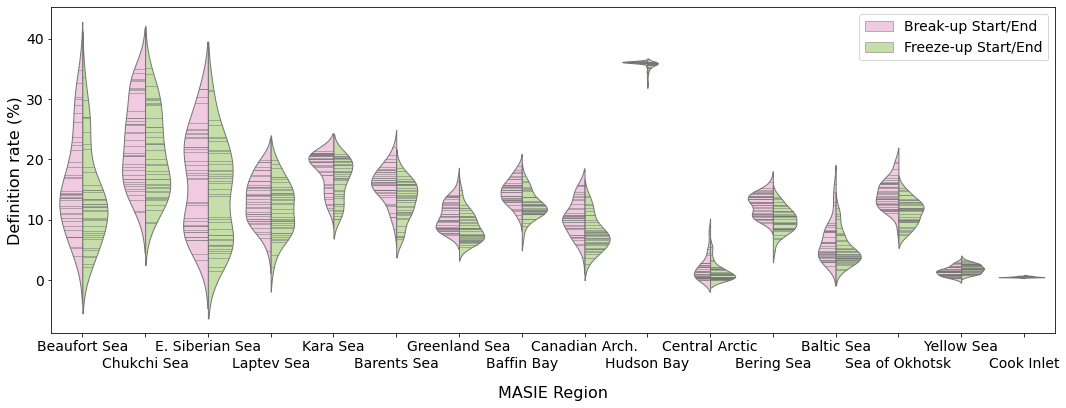

In [35]:
output_format = "png"
#output_format = "eps"

make_violin_plots(
    fubu_zs,
    "rate",
    {
        "breakup_start": "Break-up Start/End",
        "freezeup_start": "Freeze-up Start/End",
    },
    "PiYG",
    "upper right",
    "Definition rate (%)",
    out_dir.joinpath(
        f"Johnson_Eicken_definition_rate_violin_plots.{output_format}"
    ),
)

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/Johnson_Eicken_mean_freezeup_date_violin_plots.png


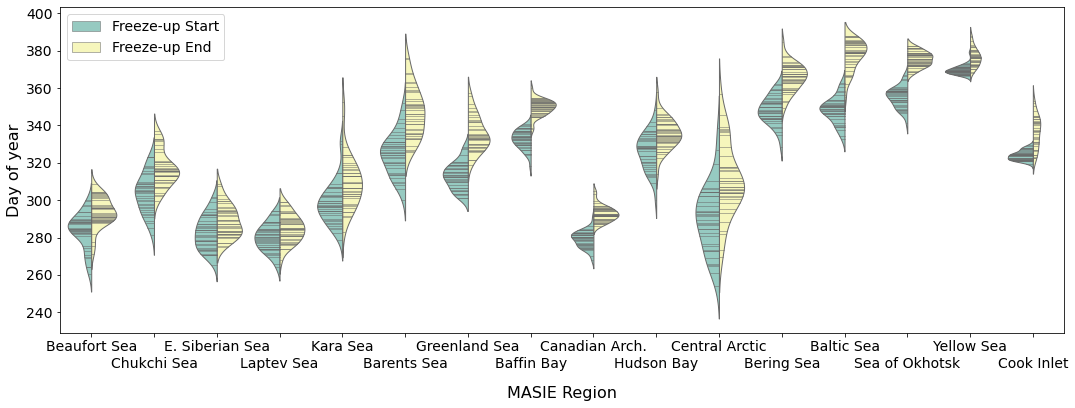

In [36]:
output_format = "png"
#output_format = "eps"

make_violin_plots(
    fubu_zs,
    "mean",
    {
        "freezeup_start": "Freeze-up Start",
        "freezeup_end": "Freeze-up End",
    },
    "Set3",
    "upper left",
    "Day of year",
    out_dir.joinpath(
        f"Johnson_Eicken_mean_freezeup_date_violin_plots.{output_format}"
    ),
)

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/Johnson_Eicken_mean_breakup_date_violin_plots.png


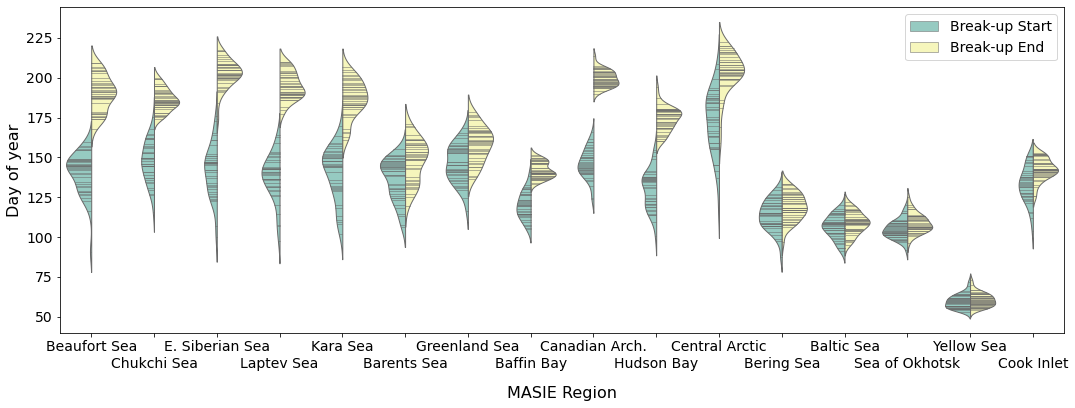

In [37]:
output_format = "png"
#output_format = "eps"

make_violin_plots(
    fubu_zs,
    "mean",
    {"breakup_start": "Break-up Start", "breakup_end": "Break-up End",},
    "Set3",
    "upper right",
    "Day of year",
    out_dir.joinpath(
        f"Johnson_Eicken_mean_breakup_date_violin_plots.{output_format}"
    ),
)

In [38]:
orac_zs = run_zonal_stats(
    orac, ["DOO", "DOR", "DOA", "DOC"], masie_polys, affine
)

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/Steele_definition_rate_violin_plots.png


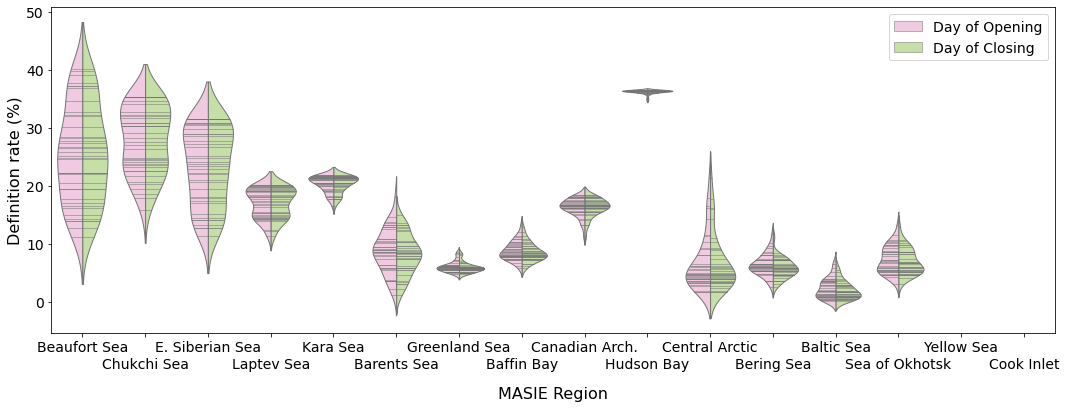

In [39]:
output_format = "png"
#output_format = "eps"

make_violin_plots(
    orac_zs,
    "rate",
    {"DOO": "Day of Opening", "DOC": "Day of Closing",},
    "PiYG",
    "upper right",
    "Definition rate (%)",
    out_dir.joinpath(
        f"Steele_definition_rate_violin_plots.{output_format}"
    ),
)

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/Steele_mean_freezeup_date_violin_plots.png


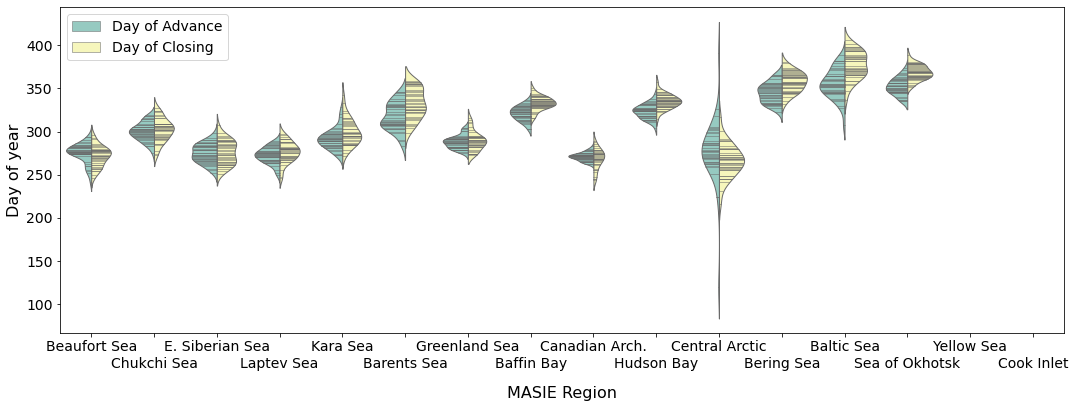

In [40]:
output_format = "png"
#output_format = "eps"

make_violin_plots(
    orac_zs,
    "mean",
    {"DOA": "Day of Advance", "DOC": "Day of Closing",},
    "Set3",
    "upper left",
    "Day of year",
    out_dir.joinpath(
        f"Steele_mean_freezeup_date_violin_plots.{output_format}"
    ),
)

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/Steele_mean_breakup_date_violin_plots.png


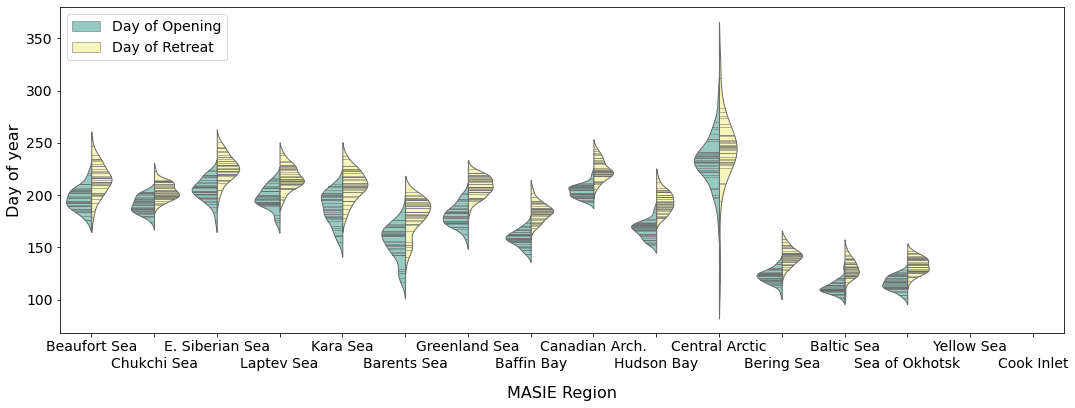

In [41]:
output_format = "png"
#output_format = "eps"

make_violin_plots(
    orac_zs,
    "mean",
    {"DOO": "Day of Opening", "DOR": "Day of Retreat",},
    "Set3",
    "upper left",
    "Day of year",
    out_dir.joinpath(
        f"Steele_mean_breakup_date_violin_plots.{output_format}"
    ),
)

In [42]:
def get_data(ma):
    """Helper function for getting only valid data
    from a masked array
    
    Args:
        ma (numpy.ma.masked_array): masked array
    
    Returns:
        array where all masked values are set to np.nan
    """
    ma.data[ma.mask == True] = np.nan
    
    return ma.data


def get_zonal_pixel_means(ds, names_lu, polys, affine):
    """Get the means of pixels within polygons using rasterstats.zonal_stats
    
    Args:
        ds (xarray.dataset): indicators dataset
        names_lu (dict): a names lookup structured as {<dataset varname>: <new varname>}
        polys (pandas.DataFrame): a data.frame of polygon geometries
        
    Returns:
        
    """
    zonal_pixel_means = {}
    for ds_varname, new_varname in zip(names_lu.keys(), names_lu.values()):
        # for each variable (indicator), 
        # use zonal_stats to get the data for a single year
        data_zs = [zonal_stats(
            polys,
            arr, 
            affine=affine, # same affine transform
            nodata=np.nan, 
            add_stats={"data": get_data}
        ) for arr in ds[ds_varname].values]
        
        # and unpack years to concatenate all data
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            
            zonal_pixel_means[new_varname] = {
                row[1]["Name"]: np.nanmean(
                    np.stack([year_stats[row[0]]["data"] for year_stats in data_zs]),
                    axis=0
                )
                for row in polys.iterrows()
            }
    
    return zonal_pixel_means

In [43]:
masie_keep_hist = ["Beaufort Sea", "Chukchi Sea", "E. Siberian Sea", "Laptev Sea"]
masie_polys_hist = masie_polys[masie_polys["Name"].isin(masie_keep_hist)]

fubu_names_lu = {
    "freezeup_start": "Freeze-up Start", 
    "freezeup_end": "Freeze-up End", 
    "breakup_start": "Break-up Start", 
    "breakup_end": "Break-up End",
}
fubu_masie_pixel_means = get_zonal_pixel_means(fubu, fubu_names_lu, masie_polys_hist, affine)
    
orac_names_lu = {
    "DOA": "Day of Advance", 
    "DOC": "Day of Closing", 
    "DOO": "Day of Opening", 
    "DOR": "Day of Retreat",
}
orac_masie_pixel_means = get_zonal_pixel_means(orac, orac_names_lu, masie_polys_hist, affine)

In [44]:
def remove_nan(arr):
    return arr[~np.isnan(arr)]

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_mean_histograms.png


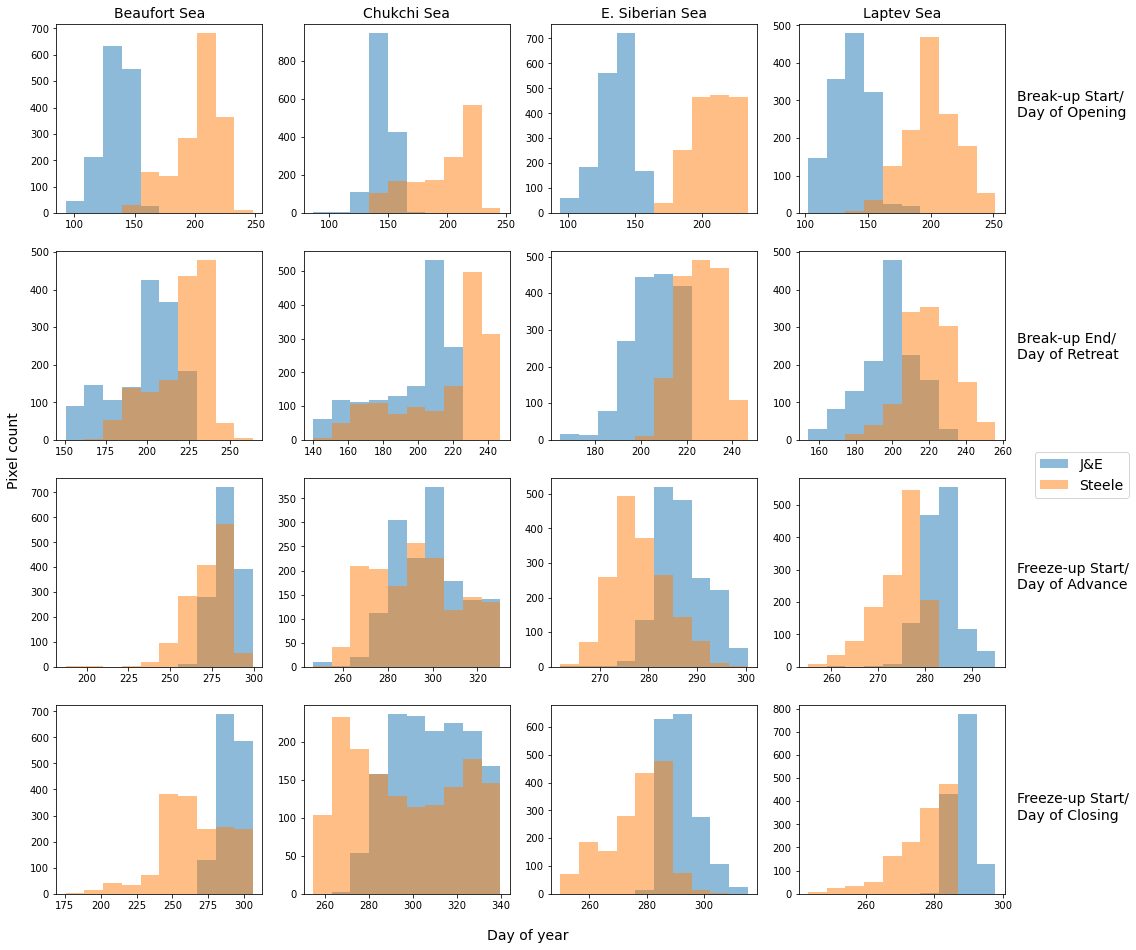

In [46]:
fubu_varnames = ["Break-up Start", "Break-up End", "Freeze-up Start", "Freeze-up End"]

orac_varname_lu = {
    "Freeze-up Start": "Day of Advance",
    "Freeze-up End": "Day of Closing",
    "Break-up Start": "Day of Opening",
    "Break-up End": "Day of Retreat",
}

fig, axs = plt.subplots(4, 4, figsize=(17,16))
for varname, i in zip(fubu_varnames, range(4)):
    for region_name, j in zip(fubu_masie_pixel_means[varname], range(4)):
        fubu_arr = remove_nan(fubu_masie_pixel_means[varname][region_name])
        orac_varname = orac_varname_lu[varname]
        orac_arr = remove_nan(orac_masie_pixel_means[orac_varname][region_name])
        counts, bins = np.histogram(np.concatenate([fubu_arr, orac_arr]))
        axs[(i,j)].hist(fubu_arr, alpha=0.5, label=varname, bins=bins)
        axs[(i,j)].hist(orac_arr, alpha=0.5, label=orac_varname, bins=bins)
        if i == 0:
            axs[(i,j)].set_title(region_name, {"fontsize": 14})
    
# row labels
row_label_x = 0.91
fig.text(row_label_x, 0.81, "Break-up Start/\nDay of Opening", va="center", fontsize=14)
fig.text(row_label_x, 0.6, "Break-up End/\nDay of Retreat", va="center", fontsize=14)
fig.text(row_label_x, 0.4, "Freeze-up Start/\nDay of Advance", va="center", fontsize=14)
fig.text(row_label_x, 0.2, "Freeze-up Start/\nDay of Closing", va="center", fontsize=14)

fig.text(0.51, 0.085, "Day of year", ha="center", fontsize=14)
fig.text(0.085, 0.51, "Pixel count", va="center", rotation="vertical", fontsize=14)

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, ["J&E", "Steele"], loc="right", fontsize=14)

save_fig(out_dir.joinpath(f"masie_mean_histograms.{output_format}"))

plt.show()

In [47]:
def make_seamask(src_fp, out_fp, src_epsg, out_epsg):
    """Make a seamask tif from a given netcdf file
    (intended for use with NSIDC-0747 file)

    Args:
        src_fp (path-like): path to netcdf file containing mask data
        out_fp (path-like): path to output mask as a .tif
        src_epsg (int): EPSG code for mask data
        out_epsg (int): EPSG code for mask data

    Returns: None, writes seamask as GeoTIFF to out_fp

    Notes:
        intended to be used for creating the maps depicting
            which point locations were used for the trends analysis
    """
    with xr.open_dataset(src_fp) as ds:
        dss = ds["DOA"].sel(time=ds["time"].values[0]).copy()
    # mask anything that is not land
    dss.values[dss.values != -4] = np.nan
    dss.values[dss.values == -4] = 0

    # reproject to out_epsg
    dss = (
        dss.rio.write_crs(f"EPSG:{src_epsg}")
        .rio.set_spatial_dims("x", "y")
        .rio.reproject(f"EPSG:{out_epsg}")
    )
    dss.rio.to_raster(out_fp, nodata=0)
    print(f"Seamask in EPSG:{out_epsg} written to {out_fp}")

    return

In [48]:
# create seamasks in scratch_dir if not present
seamask_3338_fp = scratch_dir.joinpath("seamask_3338.tif")
seamask_5938_fp = scratch_dir.joinpath("seamask_5938.tif")
make_seamask(orac_fp, seamask_3338_fp, 3411, 3338)
make_seamask(orac_fp, seamask_5938_fp, 3411, 5938)

Seamask in EPSG:3338 written to /atlas_scratch/kmredilla/seaice_noaa_indicators/seamask_3338.tif
Seamask in EPSG:5938 written to /atlas_scratch/kmredilla/seaice_noaa_indicators/seamask_5938.tif


In [49]:
# make one figure from all four maps
# use shoreline file accessed via...
gshhs_fp = scratch_dir.joinpath("GSHHS_shp/i/GSHHS_i_L1.shp")
world_shore = gpd.read_file(gshhs_fp)
world_shore = world_shore.to_crs(epsg=3338).set_index("id")

# have reprojection in 5938 as well
world_shore_5938 = world_shore.to_crs(5938)

In [50]:
point_info = {
    "Utqiaġvik": {
        "wgs84_coords": (-156.788838, 71.289736),
        "target_epsg": 3338,
        "offset_list": [(0, -1), (-1, -1), (-1, 0), (-1, 1)],
        "viewing_scale": 4,
        "world_poly": world_shore,
        "xticks": [-4e5, -2e5, 0, 2e5],
        "yticks": [2e6, 2.2e6, 2.4e6, 2.6e6],
        "xticklabels": ["-400", "-200", "0", "200"],
        "yticklabels": ["2000", "2200", "2400", "2600"],
        "labels": {
            "Utqiaġvik": {"x": 50000, "y": 2368030},
            "Chukchi\nSea": {"x": -400000, "y": 2350000},
            "Beaufort\nSea": {"x": 125000, "y": 2500000},
        },
    },
    "South Chukchi Sea": {
        "wgs84_coords": (-169, 68.34238),
        "target_epsg": 3338,
        "offset_list": [(0, 0), (0, -1)],
        "viewing_scale": 4,
        "world_poly": world_shore,
        "xticks": [-1e6, -0.8e6, -0.6e6, -0.4e6],
        "yticks": [1.8e6, 2e6, 2.2e6, 2.4e6],
        "xticklabels": ["-1000", "-800", "-600", "-400"],
        "yticklabels": ["1800", "2000", "2200", "2400"],
        "labels": {
            "Bering Strait": {"x": -620000, "y": 1800000, "rotation": 45, "backgroundcolor": "white"},
            "Chukchi\nSea": {"x": -650000, "y": 2250000},
        },
    },
    "St. Lawrence Island": {
        "wgs84_coords": (-169.912708, 62.859820),
        "target_epsg": 3338,
        "offset_list": [(0, 0), (1, 0), (1, 1)],
        "viewing_scale": 4,
        "world_poly": world_shore,
        "xticks": [-1.2e6, -1e6, -0.8e6, -0.6e6],
        "yticks": [1.2e6, 1.4e6, 1.6e6, 1.8e6],
        "xticklabels": ["-1200", "-1000", "-800", "-600"],
        "yticklabels": ["1200", "1400", "1600", "1800"],
        "labels": {
            "Bering Strait": {"x": -725000, "y": 1700000, "rotation": 45, "backgroundcolor": "white"},
            "Bering\nSea": {"x": -1100000, "y": 1500000},
            "St. Lawrence\nIsland": {"x": -800000, "y": 1400000},
        },
    },
    "Greenland Sea": {
        "wgs84_coords": (-7.480168, 80.017746),
        "target_epsg": 5938,
        "offset_list": [(0, 0), (0, -1)],
        "viewing_scale": 4,
        "world_poly": world_shore_5938,
        "xticks": [2.2e6, 2.4e6, 2.6e6, 2.8e6],
        "yticks": [0.6e6, 0.8e6, 1e6, 1.2e6],
        "xticklabels": ["2200", "2400", "2600", "2800"],
        "yticklabels": ["600", "800", "1000", "1200"],
        "labels": {
            "Greenland\nSea": {"x": 2500000, "y": 800000},
        },
    },
}

In [51]:
def reproject_coords(coords, in_epsg=4326, out_epsg=3338):
    """Reproject WGS84 coordinates

    Args:
        coords (list/tuple): 2-tuple or 2 item list of
            coordinates of point to reproject in (<lon>, <lat>) format
        in_epsg (int): EPSG code of coords
        out_epsg (int): EPSG to reproject to

    Returns:
        tuple of x, y coordinates in out_epsg, formatted as (<x>, <y>)
    """
    transformer = Transformer.from_crs(in_epsg, out_epsg, always_xy=True)

    return transformer.transform(*coords)


def get_offsets_xy(src, xy, offsets):
    """
    
    returns list of center points of pixels corresponding
    to the offsets
    """
    row, col = src.index(*xy)

    return [src.xy(row + offset[0], col + offset[1]) for offset in offsets]


def get_xy_lims(point_di):
    """Get the x, y limits for a point given the scale specified in the dict
    
    Modifies the point_di dict in place
    """
    x, y = point_di["xy_list"][0]
    scale = point_di["viewing_scale"]
    xlims = (x - scale * 1e5, x + scale * 1e5)
    ylims = (y - scale * 1e5, y + scale * 1e5)
    
    point_di["xlims"] = xlims
    point_di["ylims"] = ylims
    
    return point_di


def clip_shore_to_viewing_extent(point_di):
    """Clip the shore polygon to the extent derived from the xy lims in point_di
    
    Modify the point_di dict in place by adding new poly
    """
    xlims = point_di["xlims"]
    ylims = point_di["ylims"]
    corner_list = [
        (xlims[0], ylims[0]),
        (xlims[0], ylims[1]),
        (xlims[1], ylims[1]),
        (xlims[1], ylims[0]),
        (xlims[0], ylims[0]),
    ]
    bb = Polygon([corner for corner in corner_list])
    bb_df = gpd.GeoDataFrame(geometry=[bb]).set_crs(point_di["target_epsg"])
    point_di["shore_poly"] = gpd.overlay(bb_df, point_di["world_poly"], how="intersection")
    
    return point_di

In [52]:
for name in point_info:
    point_di = point_info[name]
    point_di["main_xy"] = reproject_coords(
        point_di["wgs84_coords"], 4326, point_di["target_epsg"]
    )
    
    # xy coords for trend analysis
    seamask_fp = str(seamask_3338_fp).replace("3338", str(point_info[name]["target_epsg"]))
    with rio.open(seamask_fp) as src:
        # get the xy coords for other cells to aggregate for each point
        point_di["xy_list"] = get_offsets_xy(
            src, point_di["main_xy"], point_di["offset_list"]
        )
        
    # subset the world shore polygon into bounding boxes corresponding to viewing windows for plotting
    # done for faster development because it takes a while to plot the whole world shoreline shapefile 
    point_di = get_xy_lims(point_di)
    point_di = clip_shore_to_viewing_extent(point_di)

In [53]:
def make_pixel_polygon_from_xy(transform, x, y):
    """Make polygon corresponding to raster pixels
    from given xy centerpoint and the raster's Affine transform
    """
    res = transform[0]
    ul = (x - (res / 2), y + (res / 2))
    corner_list = [
        ul,
        (ul[0] + res, ul[1]),
        (ul[0] + res, ul[1] - res),
        (ul[0], ul[1] - res),
        ul,
    ]
    
    return Polygon([corner for corner in corner_list])


def make_pixel_poly_gdf(transform, xy_list):
    """make GeoPandas DF of pixel polygons from xy list and transform"""
    polys = [make_pixel_polygon_from_xy(transform, *xy) for xy in xy_list]

    return gpd.GeoDataFrame(geometry=polys)


def plot_point_trends_polys(src, ax, point_di):
    """Plot the polygons for the reference maps 
    depicting which pixels were used in the point trend analysis

    Args:
        src (rasterio.io.DatasetReader): Open GeoTIFF of seamask for basemap
        ax (matplotlib.axes._subplots.AxesSubplot): Axes subplot object for working on
        xlims (list): list of lower/upper x limits ([<lower>, <upper>]) for viewing window
        ylims (list): list of lower/upper y limits ([<lower>, <upper>]) for viewing window
        offset (list): list of 2-tuples with offset values for pizels to inclue in analysis

    Returns: None, modifies ax object in place
    """
    x, y = point_di["xy_list"][0]
    point_di["shore_poly"].plot(ax=ax, facecolor="none", edgecolor="gray")

    show(src, ax=ax, vmax=10000, cmap="twilight")
    ax.set_xlim(*point_di["xlims"])
    ax.set_ylim(*point_di["ylims"])
    ax.set_xticks(point_di["xticks"])
    ax.set_yticks(point_di["yticks"])
    ax.set_xticklabels(point_di["xticklabels"])
    ax.set_yticklabels(point_di["yticklabels"])
    
    for label in point_di["labels"]:
        ax.text(**point_di["labels"][label], s=label, ha="center", fontsize=14)
    
    # plot cells that will be used
    polys = make_pixel_poly_gdf(src.transform, point_di["xy_list"])
    polys.plot(ax=ax, facecolor="none", edgecolor="red")

    return

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_maps.png


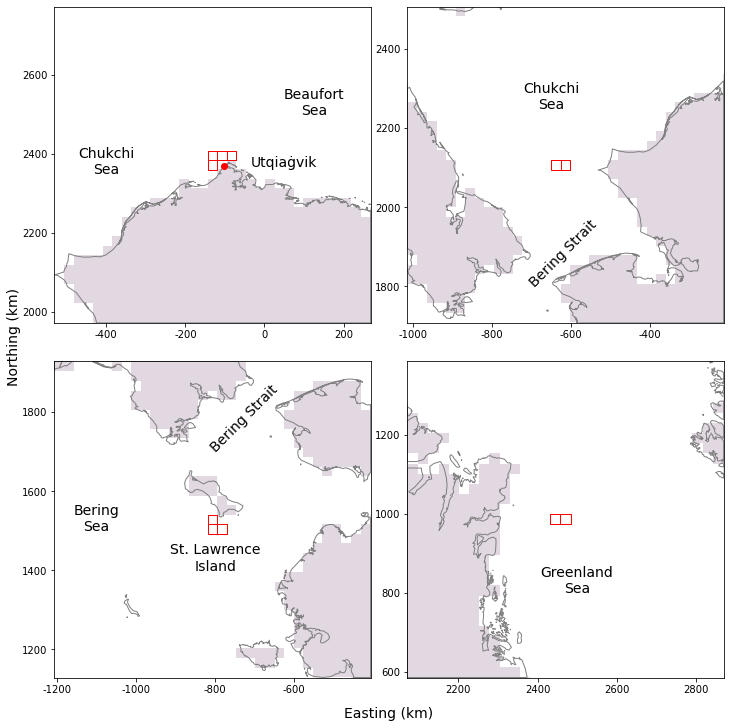

In [55]:
output_format = "png"

# initiate plot, load seamask as basemap
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
with rio.open(seamask_3338_fp) as src:
    for i in range(2):
        for j in range(2):
            # reserve final quadrant for greenland
            if i == 1 & j == 1:
                break

    for ij, name in zip(
        [(0, 0), (0, 1), (1, 0)], list(point_info.keys())[:3]
    ):
        ax = axs[ij[0], ij[1]]
        plot_point_trends_polys(src, ax, point_info[name])

# for plot in final quadrant, need greenland location and shore in 5938
with rio.open(seamask_5938_fp) as src:
    ax = axs[1, 1]
    show(src, ax=ax, vmax=10000, cmap="twilight")
    plot_point_trends_polys(
        src, ax, point_info["Greenland Sea"],
    )

fig.text(0.52, -0.01, "Easting (km)", ha="center", fontsize=14)
fig.text(-0.01, 0.52, "Northing (km)", va="center", rotation="vertical", fontsize=14)
fig.tight_layout()
# add dot for Utqiagvik
axs[0,0].scatter(*point_info["Utqiaġvik"]["main_xy"], color="red")

save_fig(out_dir.joinpath(f"point_trends_maps.{output_format}"))

plt.show()

In [56]:
# reproject xy coordinates to 3411
for name in point_info:
    point_di = point_info[name]
    point_di["xy_list_3411"] = [
        reproject_coords(xy, point_di["target_epsg"], 3411) 
        for xy in point_di["xy_list"]
    ]

In [57]:
def aggregate_pixels(ds, var_dict, xy_list, group, point_name):
    """given an xy_list and variables, make a dataframe by querying an 
    xarray dataset at the given xy locations and aggregating via mean
    """
    # empty list for holding DFs
    df_list = []
    # make a data frame for a single dataset and variable
    with warnings.catch_warnings():
        # ignore "mean of empty slice" warnings
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for var in var_dict.keys():
            df_list.append(
                pd.DataFrame.from_dict(
                    {
                        "point_name": point_name,
                        "indicator": var_dict[var],
                        "year": ds["year"].values,
                        "mean_date": np.nanmean(
                            np.array([
                                ds[var].sel(xc=xy[0], yc=xy[1], method="nearest").values 
                                for xy in xy_list
                            ]), axis=0),
                        "group": group,
                    }
                )
            )
        
    return pd.concat(df_list)

In [58]:
fubu_vars = {
    "breakup_start": "Break-up Start / Day of Opening",
    "breakup_end": "Break-up End / Day of Retreat",
    "freezeup_start": "Freeze-up Start / Day of Advance", 
    "freezeup_end": "Freeze-up End / Day of Closing", 
}
orac_vars = {
    "DOO": "Break-up Start / Day of Opening",
    "DOR": "Break-up End / Day of Retreat",
    "DOA": "Freeze-up Start / Day of Advance", 
    "DOC": "Freeze-up End / Day of Closing", 
}

point_data = pd.DataFrame()
for name in point_info:
    point_di = point_info[name]
    point_data = point_data.append(aggregate_pixels(fubu, fubu_vars, point_di["xy_list_3411"], "J&E", name))
    point_data = point_data.append(aggregate_pixels(orac, orac_vars, point_di["xy_list_3411"], "Steele", name))

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_plots.png


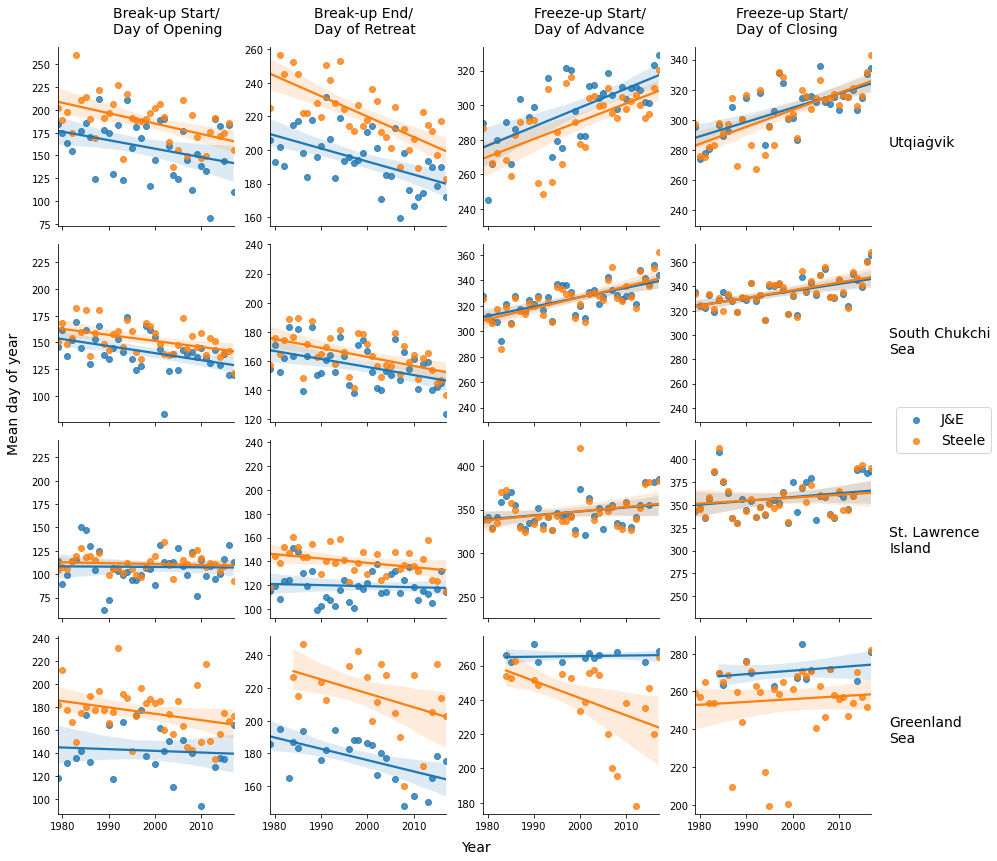

In [60]:
output_format = "png"
#output_format = "eps"

lm = sns.lmplot(x="year", y="mean_date", col="indicator", row="point_name", hue="group", data=point_data, sharey=False, height=3, legend=False)

axes = lm.axes.flatten()
for ax in axes:
    ax.set_title("")
    ax.set_ylabel("")
    ax.set_xlabel("")
    
lm.fig.text(0.48, -0.01, "Year", ha="center", fontsize=14)
lm.fig.text(-0.01, 0.52, "Mean day of year", va="center", rotation="vertical", fontsize=14)

# column labels
col_label_y = 0.95
lm.fig.text(0.1, col_label_y, "Break-up Start/\nDay of Opening", va="center", fontsize=14)
lm.fig.text(0.31, col_label_y, "Break-up End/\nDay of Retreat", va="center", fontsize=14)
lm.fig.text(0.54, col_label_y, "Freeze-up Start/\nDay of Advance", va="center", fontsize=14)
lm.fig.text(0.75, col_label_y, "Freeze-up Start/\nDay of Closing", va="center", fontsize=14)

# row labels
row_label_x = 0.91
lm.fig.text(row_label_x, 0.81, "Utqiaġvik", va="center", fontsize=14)
lm.fig.text(row_label_x, 0.58, "South Chukchi\nSea", va="center", fontsize=14)
lm.fig.text(row_label_x, 0.35, "St. Lawrence\nIsland", va="center", fontsize=14)
lm.fig.text(row_label_x, 0.13, "Greenland\nSea", va="center", fontsize=14)

# lm._legend.set_title("")
# plt.setp(lm._legend.get_texts(), fontsize=16)
lm.fig.subplots_adjust(hspace=0.1)
plt.subplots_adjust(right=0.9, top=0.92)

lm.add_legend(title="", fontsize=14, frameon=True)

save_fig(out_dir.joinpath(f"point_trends_plots.{output_format}"))

plt.show()

In [61]:
# Add column to differentiate indicators between groups
point_data["indicator_name"] = ""
combined_indicators = [
    "Break-up Start / Day of Opening", 
    "Break-up End / Day of Retreat", 
    "Freeze-up Start / Day of Advance", 
    "Freeze-up End / Day of Closing"
]
for indicator in combined_indicators:
    je_ind, steele_ind = indicator.split(" / ")
    point_data.loc[(point_data["group"] == "J&E") & (point_data["indicator"] == indicator), "indicator_name"] = je_ind
    point_data.loc[(point_data["group"] == "Steele") & (point_data["indicator"] == indicator), "indicator_name"] = steele_ind

In [62]:
from scipy import stats

rows = []
for groups, df in point_data.groupby(["point_name", "group", "indicator_name"]):
    df = df[~np.isnan(df["mean_date"])]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df["year"], df["mean_date"])
    if p_value < 0.01:
        p_value = "< 0.01**"
    elif p_value <= 0.05:
        p_value = str(round(p_value, 2)) + "*"
    else:
        p_value = str(round(p_value, 2))
    
    rows.append([*groups, round(slope, 1), round(r_value, 2), p_value])

point_lm_results = pd.DataFrame(rows, columns=["Location", "Indicator Group", "Indicator", "Slope", "r2", "p"])

In [64]:
# do some ordering and save
point_lm_results["Location"] = pd.Categorical(point_lm_results["Location"], categories=list(point_info.keys()), ordered=True)
indicator_names = [i for l in [[ind.split(" / ")[i] for ind in combined_indicators] for i in (0, 1)] for i in l]
point_lm_results["Indicator"] = pd.Categorical(point_lm_results["Indicator"], categories=indicator_names, ordered=True)
point_lm_results.sort_values(["Location", "Indicator Group", "Indicator"])

point_trends_results_fp = out_dir.joinpath("point_trends_results_table.csv")
point_lm_results.to_csv(point_trends_results_fp)
print(f"Point trends results written to {point_trends_results_fp}")
point_lm_results

Point trends results written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_results_table.csv


,Location,Indicator Group,Indicator,Slope,r2,p
0,Greenland Sea,J&E,Break-up End,-0.7,-0.59,< 0.01**
1,Greenland Sea,J&E,Break-up Start,-0.1,-0.08,0.71
2,Greenland Sea,J&E,Freeze-up End,0.2,0.29,0.36
3,Greenland Sea,J&E,Freeze-up Start,0.0,0.11,0.73
4,Greenland Sea,Steele,Day of Advance,-1.0,-0.44,0.04*
5,Greenland Sea,Steele,Day of Closing,0.1,0.09,0.59
6,Greenland Sea,Steele,Day of Opening,-0.6,-0.30,0.06
7,Greenland Sea,Steele,Day of Retreat,-0.9,-0.40,0.07
8,South Chukchi Sea,J&E,Break-up End,-0.5,-0.44,< 0.01**
9,South Chukchi Sea,J&E,Break-up Start,-0.7,-0.44,< 0.01**


In [65]:
# ignore the following regions: baltic, cook inlet, yellow sea, okhotsk
masie_discard = ["Baltic Sea", "Sea of Okhotsk", "Yellow Sea", "Cook Inlet"]
masie_polys_lm = masie_polys[~masie_polys["Name"].isin(masie_discard)]

zs = {"J&E": {}, "Steele": {}}
for group, ds in zip(zs.keys(), [fubu, orac]):
    for variable in list(ds.variables)[:4]:
        # store mask of grid cells that don't meet definition rate threshold
        ind_arr = ds[variable].values.copy()
        n = ind_arr.shape[0]
        # definition rate
        rate_arr = (~np.isnan(ind_arr)).sum(axis=0) / n
        invalid_mask = rate_arr < 0.7
        zs[group][variable] = []
        for arr in ind_arr:
            arr[invalid_mask] = np.nan
            zs[group][variable].append(
                zonal_stats(
                    masie_polys_lm, 
                    arr, 
                    affine=affine,
                    nodata=np.nan, 
                    stats=["mean"],
                )
            )
        all_year_series = []
        for year_means, year in zip(zs[group][variable], ds["year"].values):
            year_series = pd.Series({
                region_name: list(region_mean.values())[0] 
                for region_mean, region_name in zip(year_means, masie_polys.Name)
            }, name = "mean_date")
            year_series.index.name = "region"
            year_df = year_series.reset_index()
            year_df["year"] = year
            year_df["indicator"] = variable
            year_df["group"] = group
            all_year_series.append(year_df)
        
        zs[group][variable] = pd.concat(all_year_series)

zs["J&E"] = pd.concat(zs["J&E"]).reset_index().drop(columns=["level_1", "level_0"])
zs["Steele"] = pd.concat(zs["Steele"]).reset_index().drop(columns=["level_1", "level_0"])
zs_df = pd.concat(zs).reset_index().drop(columns=["level_1", "level_0"])
zs_df = zs_df.replace(fubu_vars).replace(orac_vars)

In [66]:
def plot_masie_trends(indicator_zs_df):
    lm = sns.lmplot(x="year", y="mean_date", col_wrap=4, col="region", hue="group", data=indicator_zs_df, sharey=False, height=3, legend=False)

    axes = lm.axes.flatten()
    for ax in axes:
        ax.set_title(ax.get_title().split(" = ")[1])
        ax.set_ylabel("")
        ax.set_xlabel("")

    lm.fig.text(0.46, -0.01, "Year", ha="center", fontsize=14)
    lm.fig.text(-0.01, 0.5, "Mean day of year", va="center", rotation="vertical", fontsize=14)

    # lm._legend.set_title("")
    # plt.setp(lm._legend.get_texts(), fontsize=16)
    lm.fig.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(right=0.9, top=0.92)

    lm.add_legend(title="", fontsize=14, frameon=True, borderaxespad=0.25)
    
    return lm

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_breakup_start_trends_plots.png


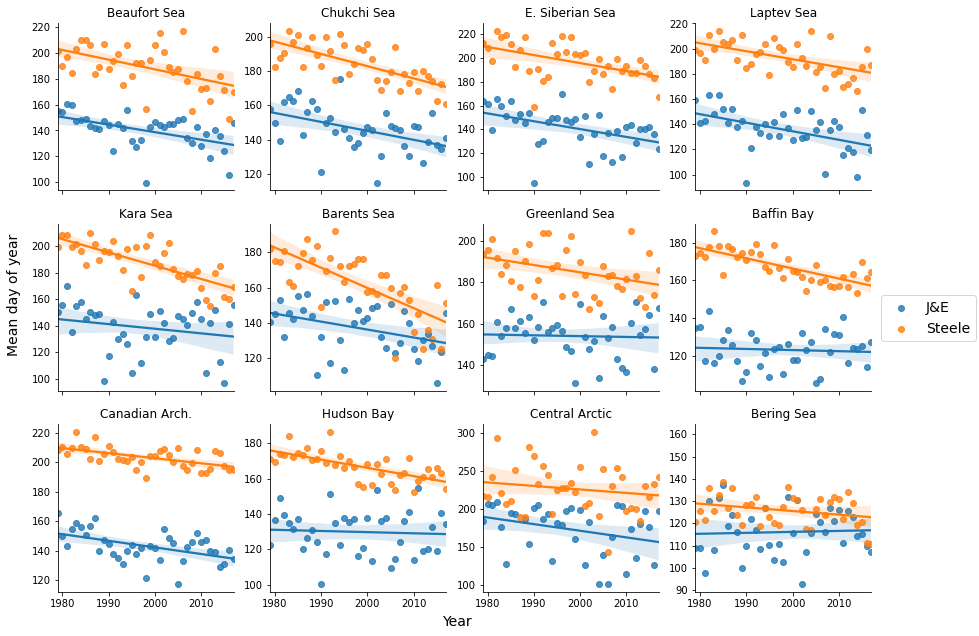

In [67]:
output_format = "png"
#output_format = "eps"

indicator_groups = list(fubu_vars.values())

masie_lm = plot_masie_trends(zs_df[zs_df["indicator"] == indicator_groups[0]])

save_fig(out_dir.joinpath(f"masie_breakup_start_trends_plots.{output_format}"))

plt.show()

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_breakup_end_trends_plots.png


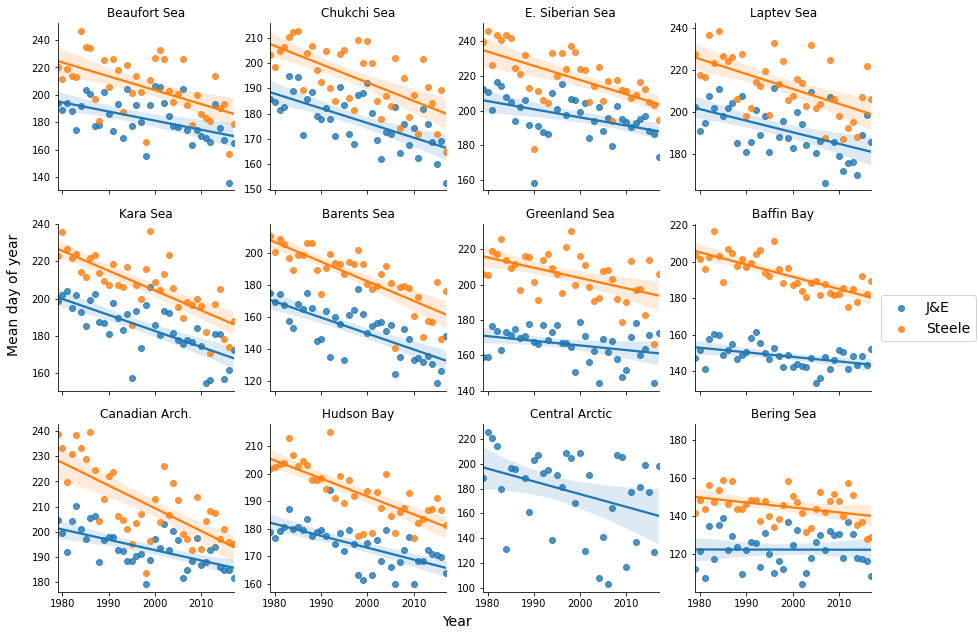

In [68]:
output_format = "png"
#output_format = "eps"

masie_breakup_end_lm = plot_masie_trends(zs_df[zs_df["indicator"] == indicator_groups[1]])

save_fig(out_dir.joinpath(f"masie_breakup_end_trends_plots.{output_format}"))

plt.show()

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_freezeup_start_trends_plots.png


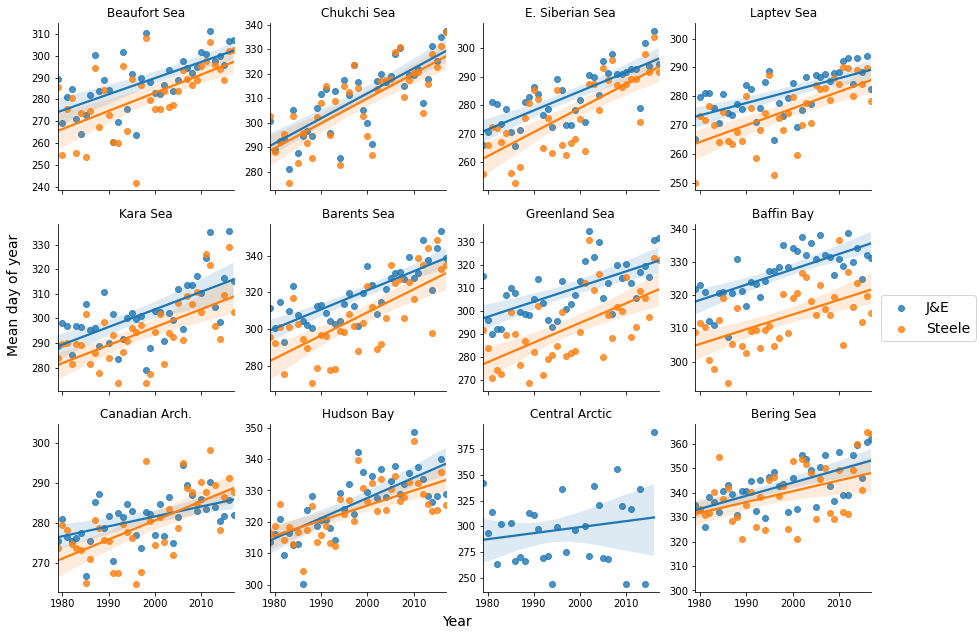

In [69]:
output_format = "png"
#output_format = "eps"

masie_lm = plot_masie_trends(zs_df[zs_df["indicator"] == indicator_groups[2]])

save_fig(out_dir.joinpath(f"masie_freezeup_start_trends_plots.{output_format}"))

plt.show()

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_freezeup_end_trends_plots.png


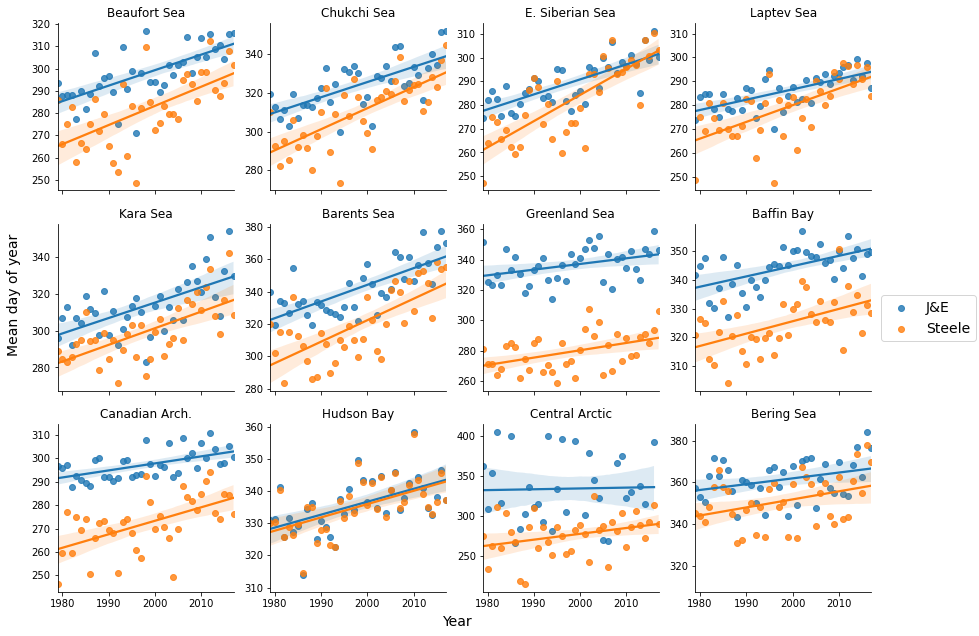

In [70]:
output_format = "png"
#output_format = "eps"

masie_lm = plot_masie_trends(zs_df[zs_df["indicator"] == indicator_groups[3]])

save_fig(out_dir.joinpath(f"masie_freezeup_end_trends_plots.{output_format}"))

plt.show()

In [71]:
# discard regions with no indicators
df = df[~np.isnan(df["mean_date"])]
rows = []
for groups, df in zs_df.groupby(["region", "group", "indicator"]):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df["year"], df["mean_date"])
    if p_value < 0.01:
        p_value = "< 0.01**"
    elif p_value <= 0.05:
        p_value = str(round(p_value, 2)) + "*"
    else:
        p_value = str(round(p_value, 2))
    
    rows.append([*groups, round(slope, 1), round(r_value, 2), p_value])

masie_lm_results = pd.DataFrame(rows, columns=["Region", "Indicator Group", "Indicator", "Slope", "r2", "p"])
masie_trends_results_fp = out_dir.joinpath("masie_trends_results_table.csv")
masie_lm_results.to_csv(masie_trends_results_fp)
print(f"MASIE trends results written to {masie_trends_results_fp}")
masie_lm_results

MASIE trends results written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_trends_results_table.csv


,Region,Indicator Group,Indicator,Slope,r2,p
0,Baffin Bay,J&E,Break-up End / Day of Retreat,-0.2,-0.44,< 0.01**
1,Baffin Bay,J&E,Break-up Start / Day of Opening,-0.1,-0.07,0.67
2,Baffin Bay,J&E,Freeze-up End / Day of Closing,0.4,0.57,< 0.01**
3,Baffin Bay,J&E,Freeze-up Start / Day of Advance,0.5,0.71,< 0.01**
4,Baffin Bay,Steele,Break-up End / Day of Retreat,-0.7,-0.77,< 0.01**
...,...,...,...,...,...,...
91,Laptev Sea,J&E,Freeze-up Start / Day of Advance,0.4,0.64,< 0.01**
92,Laptev Sea,Steele,Break-up End / Day of Retreat,-0.7,-0.58,< 0.01**
93,Laptev Sea,Steele,Break-up Start / Day of Opening,-0.6,-0.55,< 0.01**
94,Laptev Sea,Steele,Freeze-up End / Day of Closing,0.7,0.64,< 0.01**


# Appendix

This notebook provides supplementary material for the manuscript. 

## Steele indicators differences in definition totals

This section presents a summary of the differences between the Steele indicator groups total definition counts (freeze-up group: Day of Advance, Day of Closing; break-up group: Day of Opening, Day of Retreat). For the totals maps figure, we only included the Day of Opening / Day of Closing the differences between definition rates are  small to warrant depiction of totals for all four indicators. This sectin simply justifies that exclusion:

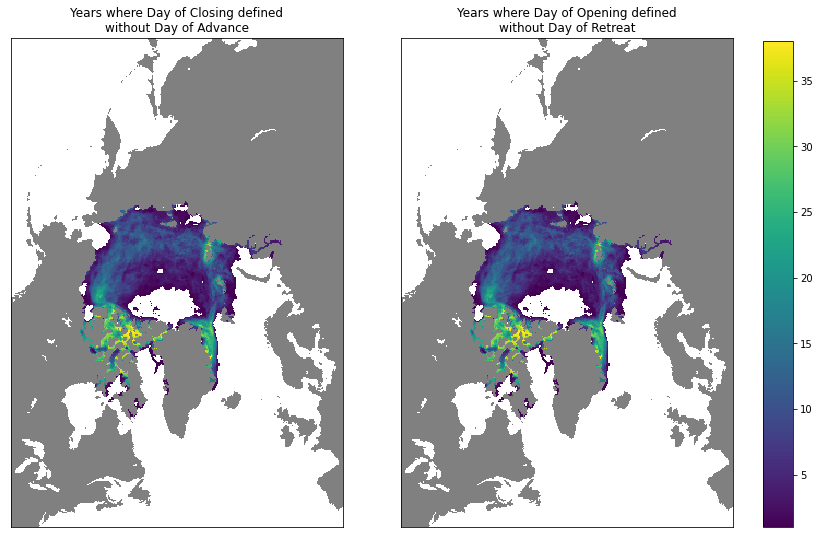

In [48]:
import copy
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr


def prep_exclusive_counts(orac_ds, indicator1, indicator2):
    """Count instances where indicator1 is defined but not
    indicator2"""
    # create array for counting and set exclusive 
    # instances to 1 and sum to count
    exclusive_arr = np.zeros_like(orac_ds["DOC"].values)
    exclusive_arr[
        (orac_ds[indicator1].values > 0) & 
        (orac_ds[indicator2].values <= 0)
    ] = 1
    
    # prep for plotting with masking
    plot_arr = np.ma.masked_where(
        orac_ds["DOA"].values[0] == -4, 
        exclusive_arr.sum(axis=0)
    )
    
    return plot_arr


def plot_exclusive_counts(plot_arrs, titles):
    cmap = copy.copy(plt.cm.get_cmap("viridis"))
    cmap.set_under(color="white")
    cmap.set_bad(color="gray")
    fig, axs = plt.subplots(1, 2, figsize=(14, 9))
    for arr,ax,title in zip(plot_arrs, axs, titles):
        im = ax.imshow(arr, interpolation="none", cmap=cmap, vmin=1, vmax=38)
        ax.title.set_text(title)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(wspace=0)
    cbar_ax = fig.add_axes([0.9, 0.125, 0.03, 0.75])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    
    return


os.environ["BASE_DIR"] = "/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/"
base_dir = Path(os.getenv("BASE_DIR"))
# computed fubu dates fp
# fubu_fp = base_dir.joinpath("nsidc_0051/outputs/nsidc_0051_1979-2019_fubu.nc")
# path to sample converted file to get landmask array
#converted_fp = list(base_dir.joinpath("nsidc_0051/prepped").glob("*"))[0]

# load fubu dates netCDF
# set up meta data for saving GeoTIFFs
# with rio.open(converted_fp) as src:
#     # defined for global reference
#     fubu_landmask = src.read(1) == 254
#     # meta = src.meta

# fubu_ds = xr.load_dataset(fubu_fp)

orac_fp = base_dir.joinpath("nsidc_0747", "arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc")
orac_ds = xr.load_dataset(orac_fp)

# keys in this dict are indicators that may be defined
# even the conjugate indicator is not 
indicator_lu = {"DOC": "DOA", "DOO": "DOR"}
plot_arrs = [prep_exclusive_counts(orac_ds, i, indicator_lu[i]) for i in ["DOC", "DOO"]]
   
# plot data
titles = [
    "Years where Day of Closing defined\nwithout Day of Advance",
    "Years where Day of Opening defined\nwithout Day of Retreat",
]

plot_exclusive_counts(plot_arrs, titles)

But the converse conditions are not true:

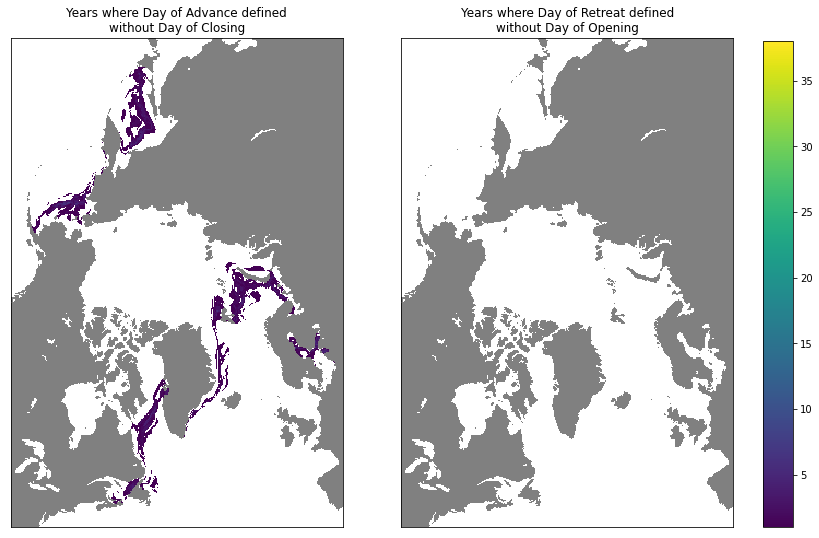

In [49]:
indicator_lu = {"DOA": "DOC", "DOR": "DOO"}
plot_arrs = [prep_exclusive_end_counts(orac_ds, i, indicator_lu[i]) for i in ["DOA", "DOR"]]
    
# plot data
titles = [
    "Years where Day of Advance defined\nwithout Day of Closing",
    "Years where Day of Retreat defined\nwithout Day of Opening",
]

plot_exclusive_counts(plot_arrs, titles)